In [1]:
%matplotlib inline
from IPython.display import Image
from IPython.display import display

import os, itertools, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# scikit-learn  0.22
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from lib import *

In [2]:
if not os.path.exists("output_HW/") : os.mkdir("output_HW/")

In [3]:
file = open('./input/train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X = np.vstack((X, np.array(row[0:2])))
    y = np.append(y, y_mapping[row[2]])
X = X.astype(np.float)
y = y.astype(np.float)
file.close()

C:\Users\acer\AppData\Local\Temp/ipykernel_24124/2375198482.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = X.astype(np.float)
C:\Users\acer\AppData\Local\Temp/ipykernel_24124/2375198482.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.float)


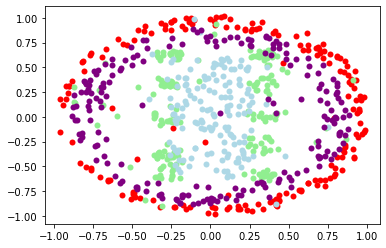

In [4]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)

In [5]:
X_train = X
y_train = y
del X, y

In [6]:
file = open('./input/test.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X = np.vstack((X, np.array(row[0:2])))
    y = np.append(y, y_mapping[row[2]])
X = X.astype(np.float)
y = y.astype(np.float)
file.close()

C:\Users\acer\AppData\Local\Temp/ipykernel_24124/3355135801.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = X.astype(np.float)
C:\Users\acer\AppData\Local\Temp/ipykernel_24124/3355135801.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y.astype(np.float)


In [7]:
X_test = X
y_test = y
del X, y

In [8]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

## 1. Train some model
由於這個Lab我是跟Lab07一起做的，因此為了方便起見，我使用支援向量機，KNN以及決策樹來做多數決的模型。
### 1.1 SVM

In [20]:
svc = SVC(random_state=1,  probability=True)

# 超參數挑選範圍
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
param_grid = [{'C': param_range, 
               'kernel': ['linear']},
              {'C': param_range, 
               'gamma': param_range, 
               'kernel': ['rbf']}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

# 輸出結果
print(gs.best_score_) # 最佳的正確率
print(gs.best_params_) # 最佳參數組合

0.8672158459829692
{'C': 100.0, 'gamma': 1.0, 'kernel': 'rbf'}


In [21]:
svc = gs.best_estimator_ # 取得剛剛算出的最佳參數
svc.fit(X_train_std, y_train) # 用這個參數train出model
print('Test accuracy of SVM: %.3f' % svc.score(X_test_std, y_test)) # 對測試集進行預測

Test accuracy of SVM: 0.849


### 1.2 KNN

In [11]:
knn = KNeighborsClassifier(metric='minkowski')

# 超參數挑選範圍
p_range = [1, 2, 3]
nb_range = [3, 5, 7, 9]
param_grid = [{'p': p_range, 
               'n_neighbors': nb_range, 
               'weights': ['uniform']},
              {'p': p_range, 
               'n_neighbors': nb_range, 
               'weights': ['distance']}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=knn, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

# 輸出結果
print(gs.best_score_) # 最佳的正確率
print(gs.best_params_) # 最佳參數組合

0.8496853017400963
{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}


In [12]:
knn = gs.best_estimator_ # 取得剛剛算出的最佳參數
knn.fit(X_train_std, y_train) # 用這個參數train出model
print('Test accuracy of KNN: %.3f' % knn.score(X_test_std, y_test)) # 對測試集進行預測

Test accuracy of KNN: 0.795


### 1.3 DecisionTreeClassifier
原本決策樹是不需要先將data做標準化的。然而這邊為了等等要做pipeline以及進行多數決，還是先以標準化過後的資料集進行訓練。不過從一開始所繪製的散佈圖來看，這些data幾乎都落在0,1之間，condition number看起來不大，即使做了標準化，分布的情形理應差不多。

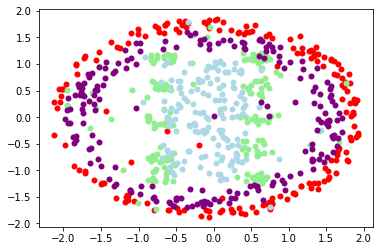

In [47]:
plt.scatter(X_train_std[y_train == 0, 0], X_train_std[y_train == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X_train_std[y_train == 1, 0], X_train_std[y_train == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X_train_std[y_train == 2, 0], X_train_std[y_train == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X_train_std[y_train == 3, 0], X_train_std[y_train == 3, 1], label='Sue', c='purple', linewidths=0)

In [13]:
tree = DecisionTreeClassifier(random_state=1)

# 超參數挑選範圍
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 
param_grid = [{'criterion':['gini','entropy'],
               'max_depth':[1, 2, 4, 6, 8, 10]}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=tree, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

# 輸出結果
print(gs.best_score_) # 最佳的正確率
print(gs.best_params_) # 最佳參數組合

0.7967789707515734
{'criterion': 'entropy', 'max_depth': 6}


In [15]:
tree = gs.best_estimator_ # 取得剛剛算出的最佳參數
tree.fit(X_train_std, y_train) # 用這個參數train出model
print('Test accuracy of DecisionTreeClassifier: %.3f' % tree.score(X_test_std, y_test)) # 對測試集進行預測

Test accuracy of DecisionTreeClassifier: 0.773


### 1.4 Make pipeline

In [22]:
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', svc]])
pipe2 = Pipeline([['sc', StandardScaler()], ['clf', knn]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', tree]])

In [28]:
clf_labels = ['SVM', 'KNN', 'DecisionTreeClassifier']
print('[Individual]')
for pipe, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=pipe, X=X_test_std, y=y_test, cv=10, scoring='accuracy')
    print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[Individual]
SVM: 0.747 (+/- 0.138)
KNN: 0.665 (+/- 0.103)
DecisionTreeClassifier: 0.756 (+/- 0.124)


## 2. Voting
使用剛剛train出來的SVM，KNN，以及決策樹做多數決。

In [29]:
print('[Voting]')
best_vt, best_w, best_score = None, (), -1
for a, b, c in list(itertools.permutations(range(0,3))): # try some weight combination
    clf = VotingClassifier(estimators=[('svc', pipe1), ('knn', pipe2), ('tree', pipe3)], 
                           voting='soft', weights=[a,b,c])
    scores = cross_val_score(estimator=clf, X=X_test_std, y=y_test, cv=10, scoring='accuracy')
    print('%s: %.3f (+/- %.3f)' % ((a,b,c), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))

[Voting]
(0, 1, 2): 0.768 (+/- 0.111)
(0, 2, 1): 0.730 (+/- 0.086)
(1, 0, 2): 0.762 (+/- 0.119)
(1, 2, 0): 0.703 (+/- 0.090)
(2, 0, 1): 0.773 (+/- 0.115)
(2, 1, 0): 0.747 (+/- 0.113)

Best (2, 0, 1): 0.773


經過多數決後可發現最好的表現是0.773，這個正確率比單一一顆決策樹可達到的0.756還要好。

## 3. Bagging
使用原本的dataset訓練決策樹與bagging模型。

In [42]:
tree = DecisionTreeClassifier(random_state=1)

# 超參數挑選範圍
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 
param_grid = [{'criterion':['gini','entropy'],
               'max_depth':[1, 2, 4, 6, 8, 10]}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=tree, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)

In [43]:
# single DecisionTree
tree = gs.best_estimator_ # 取得剛剛算出的最佳參數
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))

[DecisionTree] accuracy-train = 0.860, accuracy-test = 0.773


In [44]:
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, bootstrap=True,
                        max_samples=1.0, max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

# 超參數挑選範圍
param_range = [0.3, 0.7, 1.0] 
param_grid = [{'max_samples': param_range}]

# 使用網格搜尋法
gs2 = GridSearchCV(estimator=bag, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs2 = gs.fit(X_train, y_train)

In [45]:
# Bagging
bag = gs2.best_estimator_ # 取得剛剛算出的最佳參數
bag.fit(X_train, y_train) # 用這個參數train出model
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] accuracy-train = %.3f, accuracy-test = %.3f' % (bag_train, bag_test))

[Bagging] accuracy-train = 0.860, accuracy-test = 0.773


這是滿讓人意外的結果－－原來一顆經過條好超參數的決策樹，與bagging後的正確率是一模一樣(或著說很接近)的。

## 4. boosting models
Adaboost好像沒有可以用GridSearchCV調的參數(我試了learning_rate，可是會出現error說decision tree沒有這個參數)。

In [50]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
# single decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (tree_train, tree_test))

# adaboost
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

[DecisionTree] accuracy-train = 0.370, accuracy-test = 0.292
[AdaBoost] accuracy-train = 0.615, accuracy-test = 0.530
